In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from IPython.display import Image
!pip install conda

2024-05-06 19:01:25.340638: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 19:01:25.340769: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 19:01:25.491985: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install opencv-python
import cv2

In [3]:
import os
from pathlib import Path


dataset_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/" # For Kaggle notebooks. If you run locally, point this line to the CIFAKE directory
print("Loading dataset from: " + dataset_dir)

dataset_dir_modified = "/kaggle/working/cifake-real-and-ai-generated-synthetic-images/"

Path(dataset_dir_modified + "test_modified/FAKE").mkdir(parents=True, exist_ok=True)
Path(dataset_dir_modified + "test_modified/REAL").mkdir(parents=True, exist_ok=True)
# for all images in folder ./test
for image in os.listdir(dataset_dir + 'test/FAKE'):
    img = cv2.imread(dataset_dir + f'test/FAKE/{image}')
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # modify img_hsv
    img_hsv[:, :, 2] = img_hsv[:, :, 2] * 0.5 #lower the brightness to 50%

    img_bgr = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)
    cv2.imwrite(dataset_dir_modified + f'./test_modified/FAKE/modified_{image}', img_bgr)

for image in os.listdir(dataset_dir + 'test/REAL'):
    img = cv2.imread(dataset_dir + f'test/REAL/{image}')
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # modify img_hsv
    img_hsv[:, :, 2] = img_hsv[:, :, 2] * 0.5 #lower the brightness to 50%

    
    img_bgr = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)
    cv2.imwrite(dataset_dir_modified + f'./test_modified/REAL/modified_{image}', img_bgr)

Loading dataset from: /kaggle/input/cifake-real-and-ai-generated-synthetic-images/


In [4]:
# Check if GPUs are available for training 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
img_height = 32
img_width = 32
batch_size = 500

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "/train",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size
)

# Load the validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir_modified + "test_modified",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)


print("Training Classes:")
class_names = train_ds.class_names
print(class_names)

print("Testing Classes:")
class_names = val_ds.class_names
print(class_names)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Training Classes:
['FAKE', 'REAL']
Testing Classes:
['FAKE', 'REAL']


In [6]:
# Function for plotting the error rate and metrics rate
def plot_metrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()
    
# Constant values that will be shared by all the models
val_true_classes = np.concatenate([y for x, y in val_ds], axis = 0)  # Get true labels
class_names = ['FAKE', 'REAL']
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True) 

In [7]:
!pip install vit_keras
!pip install tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2.13.3 which is incompatible.


In [8]:
from vit_keras import vit

vit_model = vit.vit_b16(
        image_size = 32,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False)

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


347502902/347502902 [==============================] - 1s 0us/step


/opt/conda/lib/python3.10/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 2, 2
  warnings.warn(


In [9]:
# Building the Transfer Learning model using ResNet50
EfficientNet_base_model = tf.keras.applications.EfficientNetV2B0(
    include_top = False, 
    weights = 'imagenet', 
    input_shape = (img_height, img_width, 3),
    pooling = 'max'
)
EfficientNet_base_model.trainable = True

# Create a new model on top of the ResNet50 base
inputs = tf.keras.Input(shape = (img_height, img_width, 3))
x = EfficientNet_base_model(inputs, training = False)
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001)(x)
x = Dense(256, 
          kernel_regularizer = regularizers.l2(0.01), 
          activity_regularizer = regularizers.l1(0.01), 
          bias_regularizer = regularizers.l1(0.01),
          activation = 'relu')(x)
x = Dropout(rate = .4, seed = 512)(x)       
outputs_1 = Dense(64, activation = 'relu')(x)
outputs_2 = vit_model(inputs)
projection_layer = tf.keras.layers.Dense(64)
projection_o2 = projection_layer(outputs_2)
# w1 = 0.6
# w2 = 0.4
# outputs = w1 * outputs_1 + w2 * projection_o2
outputs = tf.keras.layers.Concatenate()([outputs_1, projection_o2])

outputs = Dense(1, activation = 'sigmoid')(outputs)

custom_model = tf.keras.Model(inputs, outputs)

# Compile the model
custom_model.compile(
    optimizer = tf.keras.optimizers.Adamax(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Summary of the model
custom_model.summary()


24274472/24274472 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 efficientnetv2-b0 (Functio  (None, 1280)                 5919312   ['input_3[0][0]']             
 nal)                                                                                             
                                                                                                  
 batch_normalization (Batch  (None, 1280)                 5120      ['efficientnetv2-b0[0][0]']   
 Normalization)                                                                                   
                             

In [10]:
print("Starting training with Transfer Learning using VGG16...")
custom_model_history = custom_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Transfer Learning training finished.")

Starting training with Transfer Learning using VGG16...
Epoch 1/100


I0000 00:00:1715022449.443421      82 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 [==============================] - 208s 611ms/step - loss: 1.6388 - accuracy: 0.9272 - precision: 0.9281 - recall: 0.9261 - val_loss: 0.5800 - val_accuracy: 0.8794 - val_precision: 0.8157 - val_recall: 0.9802
Epoch 2/100
200/200 [==============================] - 118s 583ms/step - loss: 0.2772 - accuracy: 0.9660 - precision: 0.9682 - recall: 0.9637 - val_loss: 0.4957 - val_accuracy: 0.8110 - val_precision: 0.7292 - val_recall: 0.9893
Epoch 3/100
200/200 [==============================] - 117s 581ms/step - loss: 0.1522 - accuracy: 0.9753 - precision: 0.9772 - recall: 0.9733 - val_loss: 0.6079 - val_accuracy: 0.7757 - val_precision: 0.6921 - val_recall: 0.9932
Epoch 4/100
200/200 [==============================] - 118s 583ms/step - loss: 0.1112 - accuracy: 0.9829 - precision: 0.9846 - recall: 0.9812 - val_loss: 0.4649 - val_accuracy: 0.8425 - val_precision: 0.7669 - val_recall: 0.9842
Epoch 5/100
200/200 [==============================] - 117s 583ms/step - loss: 0.0905 - accuracy

In [11]:
# Evaluate the model on the test dataset
val_loss, val_accuracy, val_precision, val_recall = custom_model.evaluate(val_ds)

# Print the metrics
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")

40/40 [==============================] - 7s 164ms/step - loss: 0.2823 - accuracy: 0.9162 - precision: 0.9030 - recall: 0.9326
Val Loss: 0.2823
Val Accuracy: 0.9162
Val Precision: 0.9030
Val Recall: 0.9326


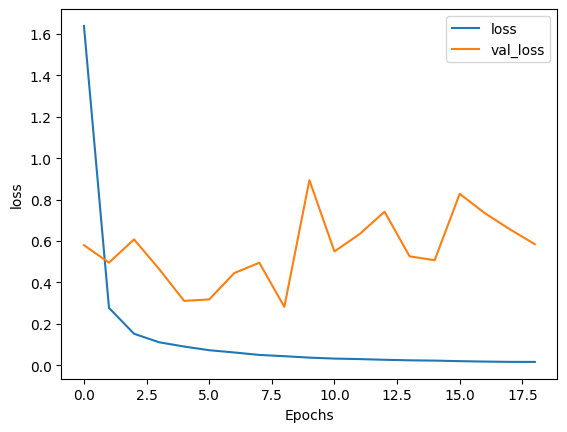

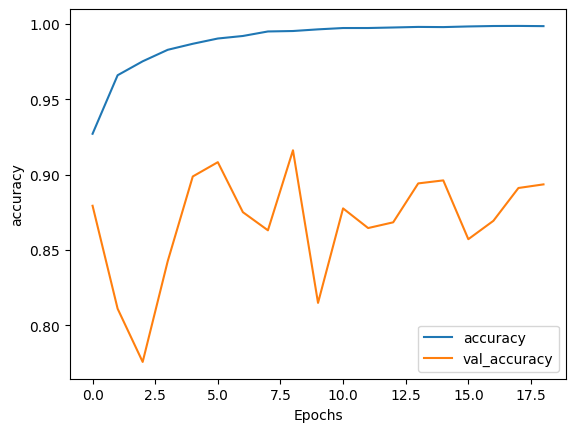

In [12]:
# Plot error rates and metric rates
plot_metrics(custom_model_history, 'loss')
plot_metrics(custom_model_history, 'accuracy')
# plot_metrics(custom_model_history, 'precision_1')
# plot_metrics(custom_model_history, 'recall_1')

In [13]:
outputs = custom_model.predict(val_ds)

40/40 [==============================] - 11s 160ms/step


Accuracy: 0.5060
F1 Score: 0.5059


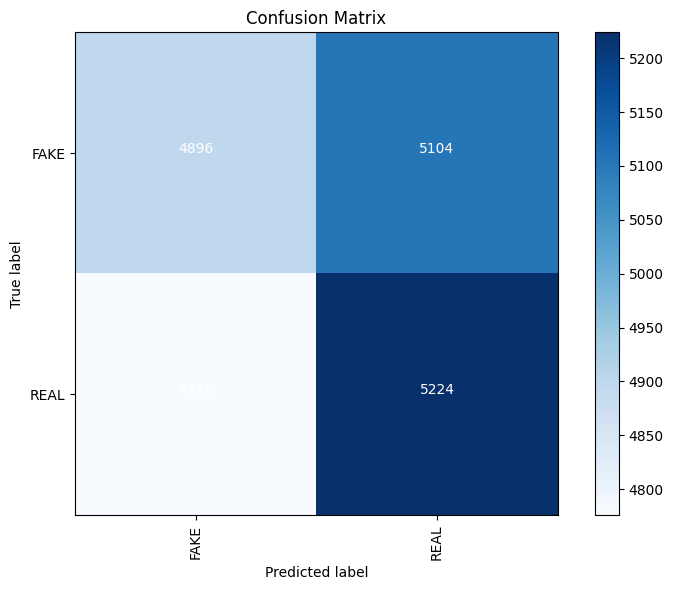


Classification report:

              precision    recall  f1-score   support

        FAKE     0.5062    0.4896    0.4978     10000
        REAL     0.5058    0.5224    0.5140     10000

    accuracy                         0.5060     20000
   macro avg     0.5060    0.5060    0.5059     20000
weighted avg     0.5060    0.5060    0.5059     20000



In [14]:
# Extract the true labels from the model outputs
# y_true = outputs.label_ids
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import itertools


y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Predict the labels by selecting the class with the highest probability
# y_pred = outputs.predictions.argmax(1)
y_pred = outputs
y_pred = (np.array(y_pred) >= 0.5).astype(int)


# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)
    
    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a small number of labels
labels_list = ["FAKE", "REAL"]
if len(labels_list) <= 150:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))
    
# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))